In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
from prophet import Prophet

In [3]:
!pip install prophet


     --------------------------------------- 13.3/13.3 MB 22.5 kB/s eta 0:00:00
     ---------------------------------------- 1.0/1.0 MB 19.2 kB/s eta 0:00:00
     --------------------------------------- 94.4/94.4 kB 36.9 kB/s eta 0:00:00


In [2]:

# Read the text file without specifying na_values
df = pd.read_csv('household_power_consumption.txt', 
                 sep=';', 
                 parse_dates={'dt': ['Date', 'Time']}, 
                 infer_datetime_format=True, 
                 low_memory=False, 
                 index_col='dt')

# Convert the columns to numeric, coercing errors to NaN
cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
        'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Check the data types and the first few rows
print(df.dtypes)
print(df.head())

# Check for missing values
print(df.isna().sum())


Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object
                     Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:24:00              18.4             0.0             1.0   
200

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [4]:
df.shape

(2075259, 7)

In [5]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [6]:
df.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [7]:
# Resample to daily frequency, computing the mean for each day
daily_data = df.resample('D').mean()
print(daily_data.head())

# Resample to monthly frequency
monthly_data = df.resample('M').mean()
print(monthly_data.head())


            Global_active_power  Global_reactive_power     Voltage  \
dt                                                                   
2006-12-16             3.053475               0.088187  236.243763   
2006-12-17             2.354486               0.156949  240.087028   
2006-12-18             1.530435               0.112356  241.231694   
2006-12-19             1.157079               0.104821  241.999313   
2006-12-20             1.545658               0.111804  242.308062   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
dt                                                                            
2006-12-16         13.082828        0.000000        1.378788       12.439394  
2006-12-17          9.999028        1.411806        2.907639        9.264583  
2006-12-18          6.421667        0.738194        1.820139        9.734722  
2006-12-19          4.926389        0.582639        5.279167        4.303472  
2006-12-20          6.467361       

In [27]:
# Step 4: Resample data to hourly sums
df_hourly = df.resample('H').mean()
df_hourly

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667
...,...,...,...,...,...,...,...
2010-11-26 17:00:00,1.725900,0.061400,237.069667,7.216667,0.0,0.000000,12.866667
2010-11-26 18:00:00,1.573467,0.053700,237.531833,6.620000,0.0,0.000000,0.000000
2010-11-26 19:00:00,1.659333,0.060033,236.741000,7.056667,0.0,0.066667,0.000000


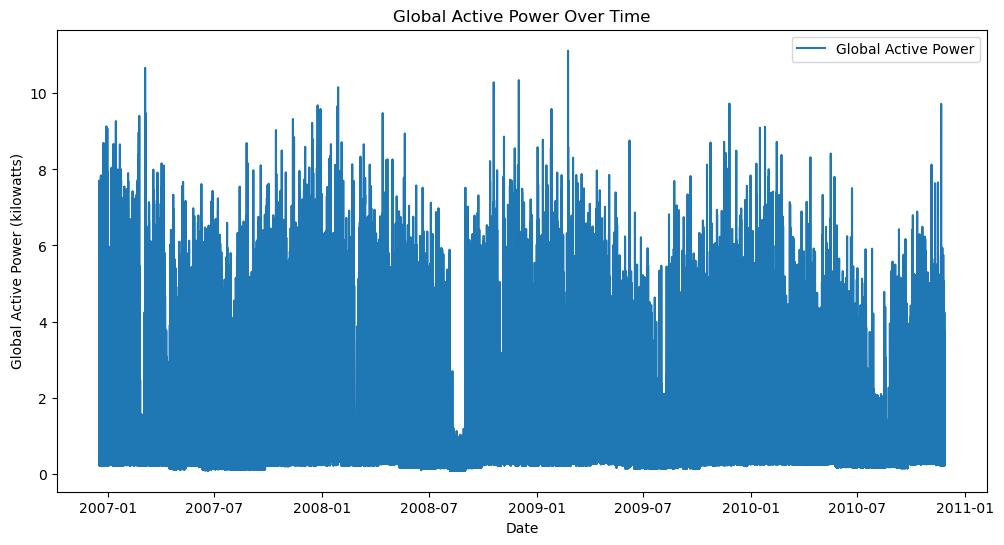

In [35]:
import matplotlib.pyplot as plt

# Plot Global_active_power over time
plt.figure(figsize=(12, 6))
plt.plot(df['Global_active_power'], label='Global Active Power')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.title('Global Active Power Over Time')
plt.legend()
plt.show()


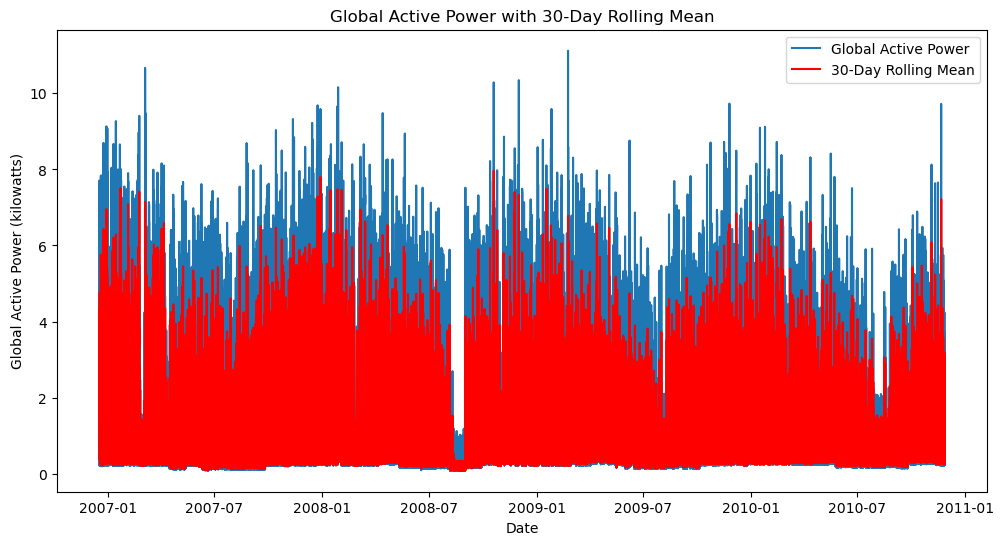

In [8]:
# Calculate rolling mean with a window of 30 days
rolling_mean = df['Global_active_power'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['Global_active_power'], label='Global Active Power')
plt.plot(rolling_mean, label='30-Day Rolling Mean', color='red')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.title('Global Active Power with 30-Day Rolling Mean')
plt.legend()
plt.show()


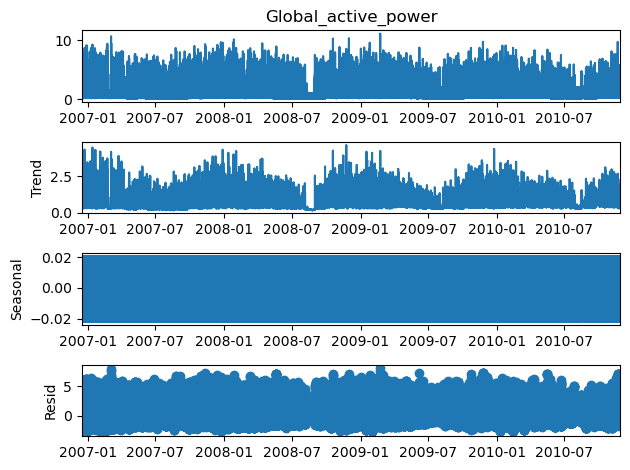

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(df['Global_active_power'].dropna(), model='additive', period=365)

# Plot the decomposed components
decomposition.plot()
plt.show()


05:49:26 - cmdstanpy - INFO - Chain [1] start processing
05:49:26 - cmdstanpy - INFO - Chain [1] done processing


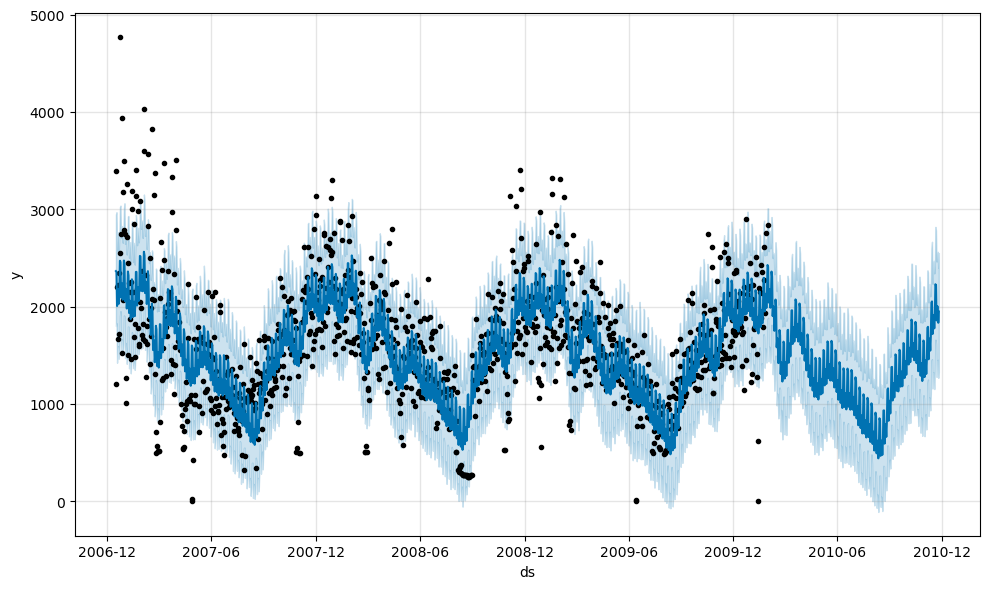

In [12]:
# Step 4: Resample data to daily sums
df_daily = df.resample('D').sum().reset_index()

# Step 5: Prepare the DataFrame for Prophet
df_daily.rename(columns={'dt': 'ds', 'Global_active_power': 'y'}, inplace=True)

# Step 6: Split into train and test sets
train = df_daily.iloc[:-300]
test = df_daily.iloc[-300:]

# Step 7: Initialize and fit the Prophet model
model = Prophet()
model.fit(train)

# Step 8: Make future predictions
future = model.make_future_dataframe(periods=300)
forecast = model.predict(future)

# Step 9: Plot the forecast
fig1 = model.plot(forecast)
plt.show()


Training RMSE: 448.9688464060863
Training MAE: 334.19705296887594
Test RMSE: 430.1851851006714
Test MAE: 313.4301856683231


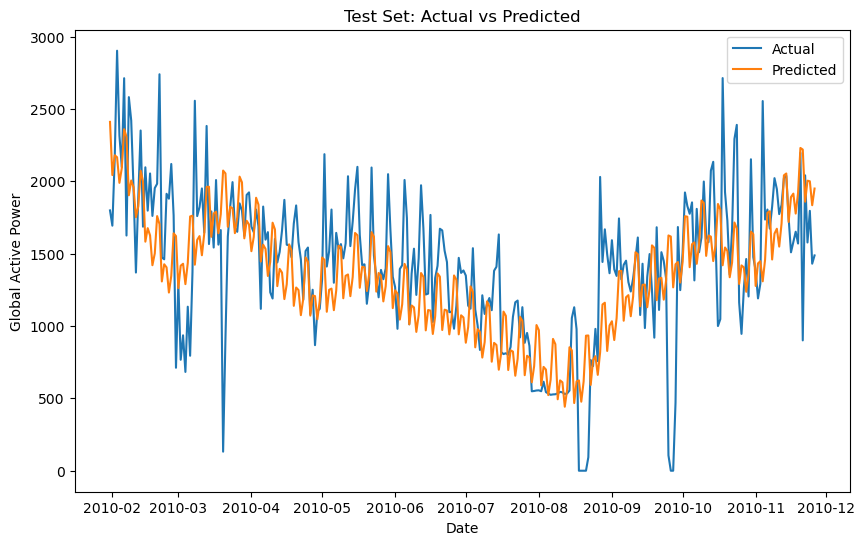

In [14]:
from sklearn.metrics import mean_absolute_error
# Step 9: Evaluate the model
test_forecast = forecast.iloc[-300:]

# Calculate RMSE and MAE for training and test sets
train_pred = forecast.iloc[:len(train)]['yhat']
test_pred = test_forecast['yhat']

rmse_train = mean_squared_error(train['y'], train_pred, squared=False)
mae_train = mean_absolute_error(train['y'], train_pred)

rmse_test = mean_squared_error(test['y'], test_pred, squared=False)
mae_test = mean_absolute_error(test['y'], test_pred)

print(f'Training RMSE: {rmse_train}')
print(f'Training MAE: {mae_train}')
print(f'Test RMSE: {rmse_test}')
print(f'Test MAE: {mae_test}')

# Step 10: Plot test set predictions against actual values
plt.figure(figsize=(10, 6))
plt.plot(test['ds'], test['y'], label='Actual')
plt.plot(test['ds'], test_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.title('Test Set: Actual vs Predicted')
plt.show()

06:28:07 - cmdstanpy - INFO - Chain [1] start processing
06:28:08 - cmdstanpy - INFO - Chain [1] done processing


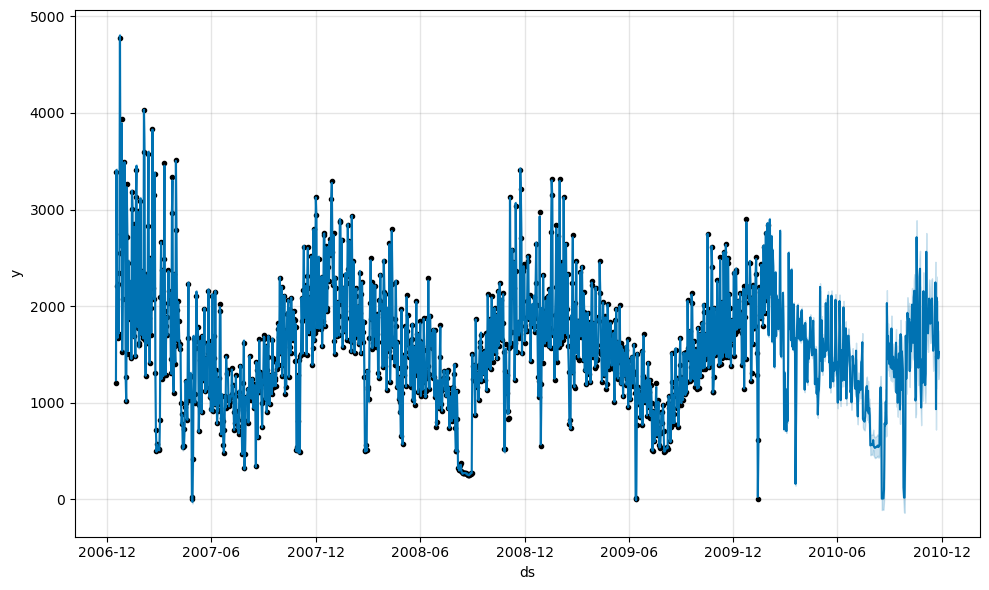

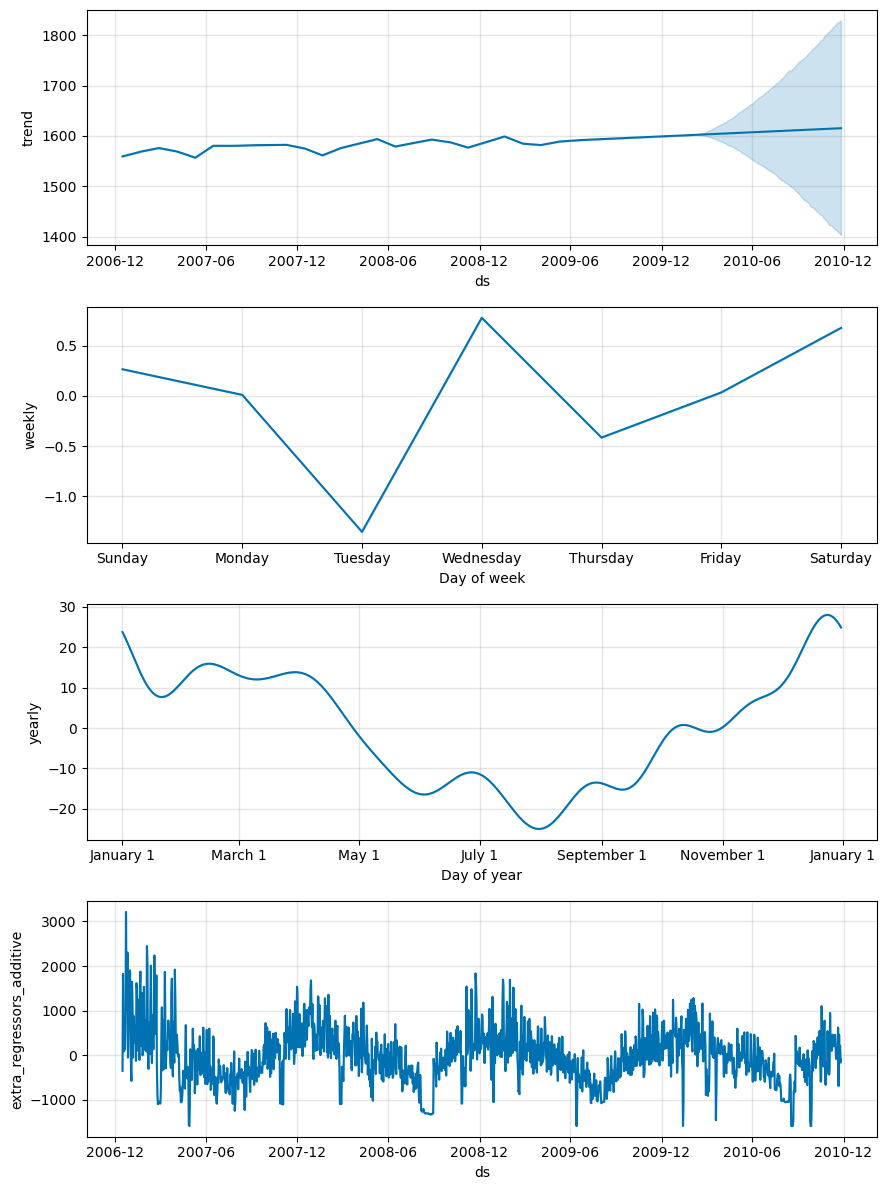

Training RMSE: 12.679582473142995
Training MAE: 9.282216349083168
Test RMSE: 20.325949517746608
Test MAE: 16.520926656522644


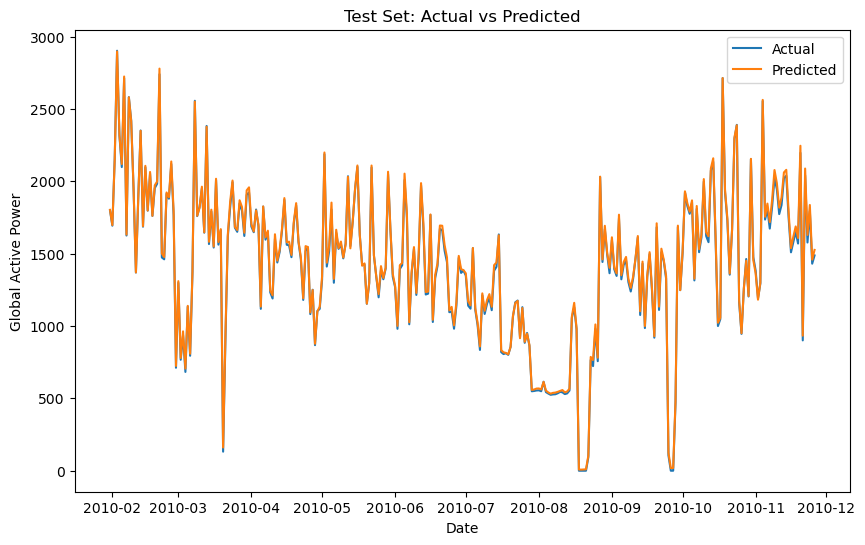

In [23]:
# Step 4: Rename the columns for Prophet and to match the regressors
df_daily.rename(columns={
    'dt': 'ds',
    'Global_active_power': 'y',
    'Global_reactive_power': 'add1',
    'Voltage': 'add2',
    'Global_intensity': 'add3',
    'Sub_metering_1': 'add4',
    'Sub_metering_2': 'add5',
    'Sub_metering_3': 'add6'
}, inplace=True)
# Step 5: Split into train and test sets
train = df_daily.iloc[:-300]
test = df_daily.iloc[-300:]

# Step 6: Initialize the Prophet model
model = Prophet()

# Step 7: Add the additional regressors
regressors = ['add1', 'add2', 'add3', 'add4', 'add5', 'add6']
for regressor in regressors:
    model.add_regressor(regressor)

# Step 8: Fit the Prophet model
model.fit(train)

# Step 9: Make future predictions
future = model.make_future_dataframe(periods=300)

# Ensure future DataFrame includes regressors for the prediction period
future = future.merge(df_daily[['ds'] + regressors], on='ds', how='left')

# Make predictions
forecast = model.predict(future)

# Step 10: Plot the forecast
fig1 = model.plot(forecast)
plt.show()

fig2 = model.plot_components(forecast)
plt.show()

# Step 11: Evaluate the model
test_forecast = forecast.iloc[-300:]

# Calculate RMSE and MAE for training and test sets
train_pred = forecast.iloc[:len(train)]['yhat']
test_pred = test_forecast['yhat']

rmse_train = mean_squared_error(train['y'], train_pred, squared=False)
mae_train = mean_absolute_error(train['y'], train_pred)

rmse_test = mean_squared_error(test['y'], test_pred, squared=False)
mae_test = mean_absolute_error(test['y'], test_pred)

print(f'Training RMSE: {rmse_train}')
print(f'Training MAE: {mae_train}')
print(f'Test RMSE: {rmse_test}')
print(f'Test MAE: {mae_test}')

# Step 12: Plot test set predictions against actual values
plt.figure(figsize=(10, 6))
plt.plot(test['ds'], test['y'], label='Actual')
plt.plot(test['ds'], test_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.title('Test Set: Actual vs Predicted')
plt.show()

In [18]:
correlation = df['Global_active_power'].corr(df['Voltage'])
correlation = round(correlation, 3)
correlation

-0.4

In [19]:
correlation_voltage_intensity = df['Voltage'].corr(df['Global_intensity'])
correlation_voltage_intensity = round(correlation_voltage_intensity, 2)
correlation_voltage_intensity

-0.41

In [20]:
mape = mean_absolute_percentage_error(test['y'], test_forecast['yhat']) * 100
mape = round(mape, 2)
mape

NameError: name 'mean_absolute_percentage_error' is not defined

In [22]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(test['y'], test_forecast['yhat']) * 100
mape = round(mape, 2)
mape

inf